In [2]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

p = sns.color_palette()

In [2]:
dfTrain = pd.read_csv('data/clicks_train.csv')

In [3]:
dfTrain.head()

,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1
3,1,156824,0
4,1,279295,0


## How many ads are in a typical display?

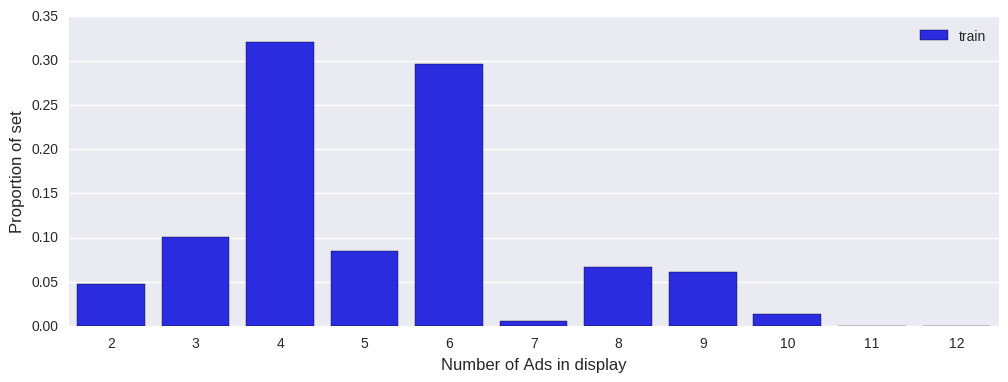

In [4]:
sizes_train = dfTrain.groupby('display_id')['ad_id'].count().value_counts()
sizes_train = sizes_train / np.sum(sizes_train)

plt.figure(figsize=(12,4));
sns.barplot(sizes_train.index, sizes_train.values, alpha=0.95, color='b', label='train');
plt.legend();
plt.xlabel('Number of Ads in display', fontsize=12);
plt.ylabel('Proportion of set', fontsize=12);

## Two major types: Displays with 4 ads (33%) and displays with 6 ads (30%)

## How many ads are shown more than once?

Ads that appear less than 2 times: 22.69%
Ads that appear less than 10 times: 61.74%
Ads that appear less than 50 times: 86.93%
Ads that appear less than 100 times: 91.04%
Ads that appear less than 1000 times: 97.45%


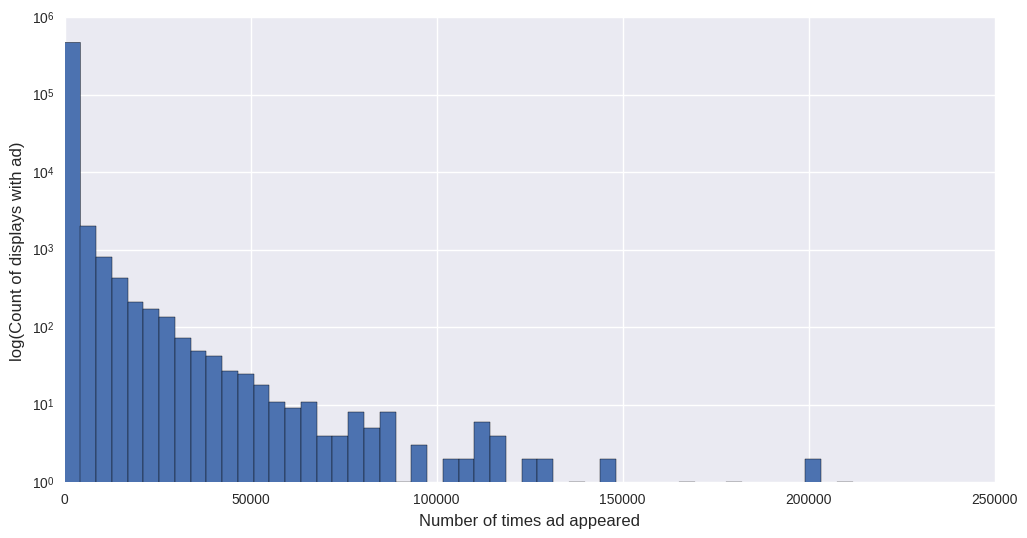

In [5]:
ad_usage_train = dfTrain.groupby('ad_id')['ad_id'].count()

for i in [2, 10, 50, 100, 1000]:
    print('Ads that appear less than {} times: {:.2f}%'.format(i, (ad_usage_train < i).mean() * 100))

plt.figure(figsize=(12, 6))
plt.hist(ad_usage_train.values, bins=50, log=True)
plt.xlabel('Number of times ad appeared', fontsize=12)
plt.ylabel('log(Count of displays with ad)', fontsize=12)
plt.show()


## So lots of ads only shown 1-10 times. Nevertheless, there are a significant number of Ads that have a large number of displays. 

In [6]:
print('There are {:,} ads in the training dataset.'.format(dfTrain['ad_id'].count()))

There are 87,141,731 ads in the training dataset.


In [8]:
numTimesAdAppeared = 15000
mostFrequentAds = ad_usage_train[ad_usage_train > numTimesAdAppeared].sort_values(ascending=False)

print ('10 most frequently displayed ads are:')
print (mostFrequentAds.iloc[0:10])
print ('Count = {}'.format(mostFrequentAds.shape[0]))
print ('This is {:.5f}% of the total ads'.format(100.0*float(mostFrequentAds.shape[0])/(dfTrain['ad_id'].count())))

10 most frequently displayed ads are:
ad_id
173005    211824
180923    203159
123742    202099
151028    181319
173006    168139
347688    147877
138353    144467
130952    135789
288396    128607
173403    128030
Name: ad_id, dtype: int64
Count = 1013
This is 0.00116% of the total ads


## So this is less than 2/1000% of total # of ads but accounts for the most displayed

In [9]:
mfID = mostFrequentAds.index[0]

In [10]:
timesClicked = dfTrain[dfTrain['ad_id'] == mfID]['clicked'].sum()
timesShown = dfTrain[dfTrain['ad_id'] == mfID]['clicked'].count()

print ('Ad was clicked %.2f%% of the time it was displayed.'%(float(timesClicked)/timesShown*100))

Ad was clicked 7.64% of the time it was displayed.


In [11]:
timesClicked

16180

In [12]:
timesShown

211824

### So the most frequently displayed ad was only clicked on 7.64% of the time. If that is true for all the most frequently displayed ads, then don't want this subset because it is too sparse to train on.

In [14]:
timesClickedTop = dfTrain[dfTrain['ad_id'].isin(mostFrequentAds.index.tolist())][['ad_id', 'clicked']]

In [15]:
clickedAll = timesClickedTop.groupby('ad_id').sum()
displayedAll = timesClickedTop.groupby('ad_id').count()

In [16]:
percentClickedAll = pd.DataFrame(clickedAll['clicked'].div(displayedAll['clicked']/100.0, 1))
percentClickedAll = percentClickedAll.rename(columns = {'clicked' : 'percentage clicked versus displayed'})

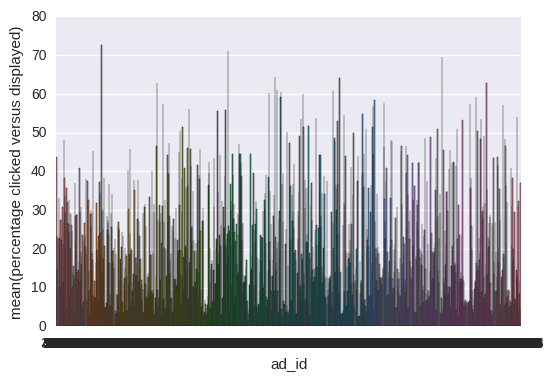

In [17]:
sns.barplot(x=percentClickedAll.index, y=percentClickedAll['percentage clicked versus displayed']);

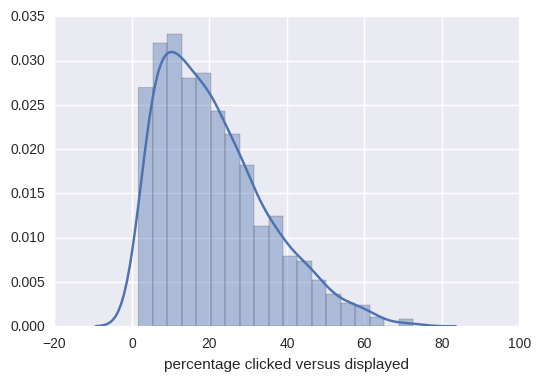

In [18]:
sns.distplot(percentClickedAll['percentage clicked versus displayed']);

## Fortunately, these 1003 ads have a really nice distribution of clicked-to-displayed ratio. So this is probably a good subset to train on for the initial pass of our pipeline. It last lots of data points and has lots of positive and negative cases, but is still a very small sample of the total training set.

In [19]:
dfTrainMFA = dfTrain[dfTrain['ad_id'].isin(mostFrequentAds.index.tolist())]

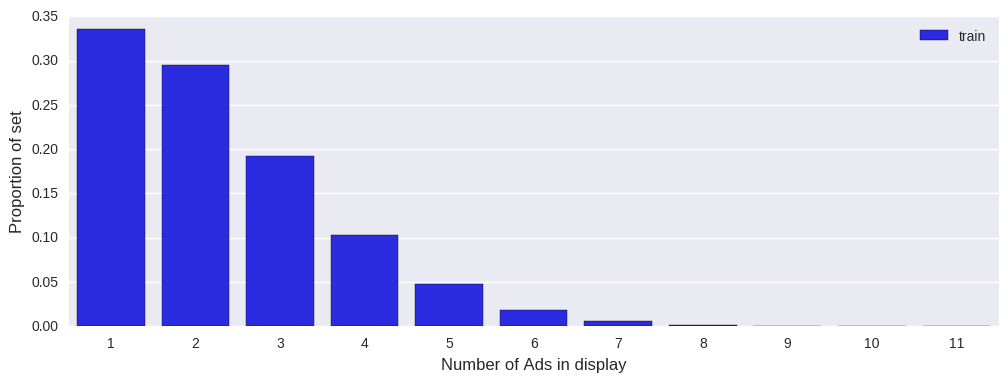

In [20]:
sizes_train = dfTrainMFA.groupby('display_id')['ad_id'].count().value_counts()
sizes_train = sizes_train / np.sum(sizes_train)

plt.figure(figsize=(12,4));
sns.barplot(sizes_train.index, sizes_train.values, alpha=0.95, color='b', label='train');
plt.legend();
plt.xlabel('Number of Ads in display', fontsize=12);
plt.ylabel('Proportion of set', fontsize=12);

## Ok. So that's a little concerning. Most of our ads in the subset are only being displayed alone or with 1 or 2 other ads. So in that respect it is *not* a good subsample (but perhaps it is still good enough).

### Kyle and I came across a useful observation about the data:  There are many display_id where only one ad is displayed. So in those cases, the solution is just showing the display_id and the one ad_id. 

### TODO: Let's create a submission file where we just pass back the display_id and the ad_id and see what score we get. We know we should get the display_ids with only 1 ad 100% correct and the display_ids with 2 ads 50% correct, 3 ads (1/3!)*100=16.6% correct, and so forth. So we can probably even calculate the expected probability:

$\large\frac{1}{count(\text{number of displays})} * \sum_{i=1}^{12}{\frac{count(\text{displays with i advertisment(s)})}{i!}}
 $
 
 for displays with up to 12 ads per display

In [3]:
dfTest = pd.read_csv('data/clicks_test.csv')

In [22]:
dfTest.head()

,display_id,ad_id
0,16874594,66758
1,16874594,150083
2,16874594,162754
3,16874594,170392
4,16874594,172888


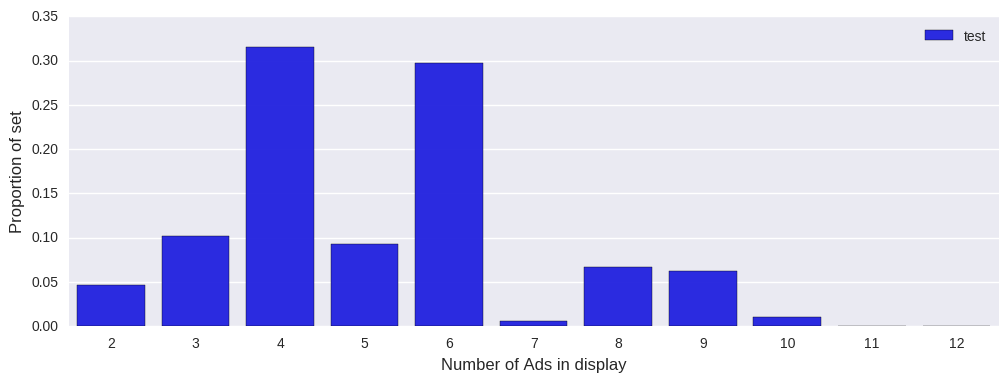

In [24]:
sizes_test = dfTest.groupby('display_id')['ad_id'].count().value_counts()
sizes_test = sizes_test / np.sum(sizes_test)

plt.figure(figsize=(12,4));
sns.barplot(sizes_test.index, sizes_test.values, alpha=0.95, color='b', label='test');
plt.legend();
plt.xlabel('Number of Ads in display', fontsize=12);
plt.ylabel('Proportion of set', fontsize=12);

In [26]:
counts_test = dfTest.groupby('display_id')['ad_id'].count().value_counts()

In [29]:
from math import factorial

sum([float(c)/factorial(i)/counts_test.sum() for i, c in enumerate(counts_test.tolist())])

0.6817875278021529

## So if our math logic is correct, then there we should get 68% of the predictions correct by **doing absolutely nothing to the test data**!  Right????

# So let's just group the test file by display_id and output it as our submission file.

In [17]:
uniqueAds = dfTest.groupby('display_id')

## Now it's a dataframe where all ads are grouped with their display_id. Let's get all of the unique display_ids

In [26]:
uniqueDisplayIDs = dfTest['display_id'].unique()

In [31]:
uniqueAds['ad_id'].get_group(uniqueDisplayIDs[0]).tolist()

[66758, 150083, 162754, 170392, 172888, 180797]

### This function just reformats a list without the [] so that we can pass it as a CSV

In [48]:
def printListCSV(list1):
    return format(', '.join(str(e) for e in list1))

print('{}, {}'.format(uniqueDisplayIDs[0], printListCSV(uniqueAds['ad_id'].get_group(uniqueDisplayIDs[0]).tolist())))

16874594, 66758, 150083, 162754, 170392, 172888, 180797


## Now just loop through the test data (grouped by displayID) and output the displayID and all ads associated with that displayID. Write it to our submission file. No actual data processing.

In [ ]:
with open('data/submission.csv', 'w') as fp:
    for displayID in uniqueDisplayIDs:
      fp.write('{}, {}\n'.format(displayID, 
                                 printListCSV(uniqueAds['ad_id'].get_group(displayID).tolist())))